In [389]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.simplefilter("ignore")

In [8]:
df = pd.read_csv('wvs.csv',sep='\t')

## Provided Information:

###### We are using Wave 6 data: 2013-2014
###### Not all countries are participating in each wave.
###### In this problem set we focus on what the respondents think about abortion (V204), I_ABORTLIB (Emancipative Value)

### 1 Explore and prepare the data
###### 1. Load the data. How many responses and variables do we have?

In [21]:
print("There are:",df.shape[0], "responses and",df.shape[1],"variables")

There are: 90350 responses and 328 variables


###### 2. Create a summary table over all responses for V204 : is abortion justifiable. How many nonmissing responses (i.e. positive answers) do you find? Describe the the opinion about the abortion among the global pool of respondents.

In [28]:
# Replacing the negative values with 0. 0 will represent missing values
df['V204'] = [0 if x<0 else x for x in df['V204']]

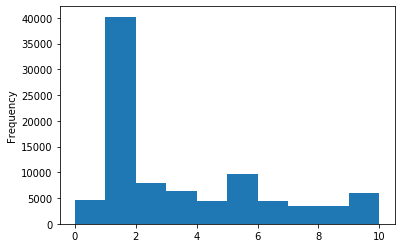

In [30]:
df['V204'].plot(kind='hist')

###### Summary Table

In [34]:
print(pd.value_counts(df['V204']))

1     40227
5      9580
2      7896
3      6294
0      4608
4      4497
6      4395
10     4067
7      3493
8      3397
9      1896
Name: V204, dtype: int64


###### Non-missing responses (i.e. positive answers)

In [41]:
# Values that are non-missing. 
pd.value_counts(df['V204']>0)
# 85742 values are non-missing

True     85742
False     4608
Name: V204, dtype: int64

######  (3) Now remove missings
###### (a) remove everything that are not positive integers for V204 and V2 (country)

In [52]:
df_new = df[(df['V204']>0) & (df['V2']>0)]

###### (b) ) for all other variables, remove the missings in the sense of missing value on computer. You may leave negative answers in the data, otherwise I am afraid your sample size collapses. What is the final number of observations?

In [54]:
df_new.dropna(inplace=True)
print("Final number of observations: ", len(df_new))

Final number of observations:  79267


/Users/saransharora/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


###### (4) In order to simplify the analysis below, create a new binary variable abortion as abortion =>  1: V204 > 3, 0: otherwise

In [56]:
df_new['V204'] = [1 if x>3 else 0 for x in df_new['V204']]

/Users/saransharora/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


###### (5) Compute (pearson) correlation table between abortion and all other variables in the data.

In [92]:
#Taking minimum values as 50000 to avoid confusion. 
df_corr = df_new.corr(min_periods=20000).V204

In [93]:
df_corr = pd.DataFrame(data = df_corr.values, index = df_corr.index, columns = ['Pearson_Correlation'])

In [95]:
df_corr.sort_values(by='Pearson_Correlation', ascending=False, inplace=True)

In [97]:
print("20 most correlated variables:\n")
print(df_corr.head(20))

20 most correlated variables:

            Pearson_Correlation
V204                   1.000000
V205                   0.548653
V203                   0.485419
V206                   0.446394
V207                   0.418271
V9                     0.314117
V203A                  0.291576
V146                   0.272220
V210                   0.257035
V19                    0.249042
V202                   0.246232
V145                   0.243545
V200                   0.239010
V147                   0.224269
I_RELIGBEL             0.217138
V153                   0.210643
V199                   0.204017
V185                   0.198473
V201                   0.197711
V79                    0.197341


###### The top 5 most correlated variables are:

###### V205 - Divorse
###### V203 - Homosexuality
###### V206 - Sex before marriage
###### V207 - Suicide
###### V9 - Religion

###### (6) Convert country code V2 into dummies. First rename V2 to country. 

In [100]:
df_new.rename({'V2':'country'}, axis=1, inplace=True)

/Users/saransharora/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [105]:
# Resetting Index
df_new.reset_index(drop=True, inplace=True)

In [106]:
data_c = pd.get_dummies(df_new.country)

In [113]:
# Dropping column to avoid perfect multicollinearity.
data_c.drop(labels=[887], axis=1, inplace=True)

# 2.  Implement Cross-Validation 

In [457]:
# Top 21 correlated variables with V204. Removing the first variable V204. Using these 20 variables as features
corr_index = df_new.columns.to_list()
corr_index.remove('V204')
target_index = ['V204']
corr_index_1 = corr_index
corr_index_1 = corr_index_1.remove('country')

In [456]:
def dataframe(data,k, model, corr_index, target_index):
    f1_ss = []
    accuracy_s = []
    for cross in range(k):
        ind = data.index.values
        random.shuffle(ind)
        li_valid = []
        for i in range(1,round(len(ind)/k)):
            li_valid.append(ind[i*k-1])
        li_train = list(set(ind) ^ set(li_valid))
        li_train = list(li_test)
        validation_df = data.loc[li_valid]
        training_df = data.loc[li_train]
        try:
            train_x = training_df[corr_index]
        except:
            train_x = training_df[corr_index_1]
        train_y = training_df[target_index]
        try:
            test_x = validation_df[corr_index]
        except:
            test_x = validation_df[corr_index_1]
        test_y = validation_df[target_index]
        fitted = model.fit(train_x, train_y)
        y_pred = fitted.predict(test_x)
        accuracy = accuracy_score(y_pred, test_y)
        accuracy_s.append(accuracy)
        f1_s = f1_score(test_y, y_pred,average='weighted')
        f1_ss.append(f1_s)
        
    acc_avg = sum(accuracy_s)/len(accuracy_s)
    f1_avg = sum(f1_ss)/len(f1_ss)
        
    return f1_avg, acc_avg
        
        

# 3. Best Fit Model

### 3.1 k-NN Model (N=3)

In [435]:
df_new = df_new[50000:52000]
df_new.reset_index(drop=True, inplace=True)

In [438]:
%%time
knn = KNeighborsClassifier(n_neighbors=3)
f1_3, acc_3 = dataframe(df_new, 5, knn,  corr_index, target_index)
print("k-NN F1 Score: ", f1_3, "k-NN Accuracy", acc_3)

k-NN F1 Score:  0.635624357744007 k-NN Accuracy 0.6155388471177945
CPU times: user 283 ms, sys: 17.2 ms, total: 301 ms
Wall time: 356 ms


### k-NN Model (N=1)

In [440]:
%%time
knn = KNeighborsClassifier(n_neighbors=1)
f1_1, acc_1 = dataframe(df_new, 5, knn,  corr_index, target_index)
print("k-NN F1 Score: ", f1_1, "k-NN Accuracy", acc_1)

k-NN F1 Score:  0.6435380665071087 k-NN Accuracy 0.6215538847117794
CPU times: user 261 ms, sys: 8.46 ms, total: 270 ms
Wall time: 282 ms


### k-NN Model (N=5)

In [441]:
%%time
knn = KNeighborsClassifier(n_neighbors=5)
f1_5, acc_5 = dataframe(df_new, 5, knn,  corr_index, target_index)
print("k-NN F1 Score: ", f1_5, "k-NN Accuracy", acc_5)

k-NN F1 Score:  0.6630076746146054 k-NN Accuracy 0.6506265664160401
CPU times: user 275 ms, sys: 13.7 ms, total: 288 ms
Wall time: 301 ms


### Best k-NN model

In [442]:
print("Best F1-Score (k=1)",f1_1,"and Best Accuracy (k=1)",acc_1 )

Best F1-Score (k=1) 0.6435380665071087 and Best Accuracy (k=1) 0.6215538847117794


### 3.2 Logistic Regression

In [443]:
%%time
lr = LogisticRegression()
f1_lr, acc_lr = dataframe(df_new, 5, lr,  corr_index, target_index)
print("Logistic Regression F1 Score: ", f1_lr, "Logistic Regression Accuracy", acc_lr)

Logistic Regression F1 Score:  0.5333048224948369 Logistic Regression Accuracy 0.5012531328320803
CPU times: user 234 ms, sys: 95.4 ms, total: 330 ms
Wall time: 421 ms


### 3.3 Support Vector Machine (kernal --> linear)

In [444]:
%%time
svclassifier_linear = SVC(kernel='linear')
f1_linear, acc_linear = dataframe(df_new, 5, svclassifier_linear,  corr_index, target_index)
print("SVM Linear kernal F1 Score: ", f1_linear, "SVM Linear kernal Accuracy", acc_linear)

SVM Linear kernal F1 Score:  0.5299730523090227 SVM Linear kernal Accuracy 0.500250626566416
CPU times: user 167 ms, sys: 12.9 ms, total: 180 ms
Wall time: 204 ms


### Support Vector Machine (kernal --> polynomial (degree 1,2,3,4))

In [445]:
%%time
svclassifier_poly1 = SVC(kernel='poly', degree=1)
f1_poly1, acc_poly1 = dataframe(df_new, 5, svclassifier_poly1,  corr_index, target_index)
print("SVM polynomial 1 kernal F1 Score: ", f1_poly1, "SVM polynomial 1 kernal Accuracy", acc_poly1)

SVM polynomial 1 kernal F1 Score:  0.6847697224105929 SVM polynomial 1 kernal Accuracy 0.66265664160401
CPU times: user 191 ms, sys: 17 ms, total: 208 ms
Wall time: 236 ms


In [447]:
%%time
svclassifier_poly2 = SVC(kernel='poly', degree=2)
f1_poly2, acc_poly2 = dataframe(df_new, 5, svclassifier_poly2,  corr_index, target_index)
print("SVM polynomial 2 kernal F1 Score: ", f1_poly2, "SVM polynomial 2 kernal Accuracy", acc_poly2)

SVM polynomial 2 kernal F1 Score:  0.5472701118612288 SVM polynomial 2 kernal Accuracy 0.5177944862155389
CPU times: user 165 ms, sys: 5.74 ms, total: 171 ms
Wall time: 179 ms


In [448]:
%%time
svclassifier_poly3 = SVC(kernel='poly', degree=3)
f1_poly3, acc_poly3 = dataframe(df_new, 5, svclassifier_poly3,  corr_index, target_index)
print("SVM polynomial 3 kernal F1 Score: ", f1_poly3, "SVM polynomial 3 kernal Accuracy", acc_poly3)

SVM polynomial 3 kernal F1 Score:  0.5232018941690986 SVM polynomial 3 kernal Accuracy 0.4957393483709273
CPU times: user 165 ms, sys: 7.8 ms, total: 173 ms
Wall time: 178 ms


In [449]:
%%time
svclassifier_poly4 = SVC(kernel='poly', degree=4)
f1_poly4, acc_poly4 = dataframe(df_new, 5, svclassifier_poly4,  corr_index, target_index)
print("SVM polynomial 4 kernal F1 Score: ", f1_poly4, "SVM polynomial 4 kernal Accuracy", acc_poly4)

SVM polynomial 4 kernal F1 Score:  0.5451153871817713 SVM polynomial 4 kernal Accuracy 0.5137844611528821
CPU times: user 170 ms, sys: 6.56 ms, total: 176 ms
Wall time: 180 ms


In my opinion, the F1 score, which depends on precision and recall is getting lower as I increase the dimensions because of miss classifications. The Support vector classifier miss classifies the cases based on the threshold value, which might be calculated incorrectly

### 3.4 Compare the models

In [450]:
print("Best F1-Score (k=1)",f1_1,"and Best Accuracy (k=1)",acc_1 )
print("Logistic Regression F1 Score: ", f1_lr, "Logistic Regression Accuracy", acc_lr)
print("SVM Linear kernal F1 Score: ", f1_linear, "SVM Linear kernal Accuracy", acc_linear)
print("SVM polynomial 1 kernal F1 Score: ", f1_poly1, "SVM polynomial 1 kernal Accuracy", acc_poly1)
print("SVM polynomial 2 kernal F1 Score: ", f1_poly2, "SVM polynomial 2 kernal Accuracy", acc_poly2)

Best F1-Score (k=1) 0.6435380665071087 and Best Accuracy (k=1) 0.6215538847117794
Logistic Regression F1 Score:  0.5333048224948369 Logistic Regression Accuracy 0.5012531328320803
SVM Linear kernal F1 Score:  0.5299730523090227 SVM Linear kernal Accuracy 0.500250626566416
SVM polynomial 1 kernal F1 Score:  0.6847697224105929 SVM polynomial 1 kernal Accuracy 0.66265664160401
SVM polynomial 2 kernal F1 Score:  0.5472701118612288 SVM polynomial 2 kernal Accuracy 0.5177944862155389


The best accuracy is given by SVM with a polynomial 1. The accuracy is 0.68
The best F1 score is given by SVM with a polynomial 1. The F1 score is 0.66
In terms of running time, Logistic regression took the most time (total: 421 ms), and the least time was taken by SVM Polynomial (3) kernel (total: 178 ms). Generally k-NN models took more time, and SVM models took the least time. It could be because SVM models calculate relationships AS IF they are in the higher dimension, but do not actually transform the data into a higher dimension. 

If I could pick up one model, I would pick up SVM with a linear kernel. It has the best accuracy and F1 score. Also, it taken less computation time as compared to other models. 

# 4. How large a role does country play?

##### Best model: SVM with linear kernel

In [410]:
# Making a copy of the original dataframe
df_countryrole = df_new.copy()

In [453]:
# Dropping the 'country' column and combining dummy variables with the main dataframe
df_country = df_countryrole.drop(columns=['country'], axis=1)
df_countrydummies = pd.concat([data_c, df_country], axis=1, sort=False)

##### Using all countries as dummy variable

In [458]:
%%time
svclassifier_linear_all = SVC(kernel='linear')
f1_linear_all, acc_linear_all = dataframe(df_countrydummies, 5, svclassifier_linear_all,  corr_index, target_index)
print("SVM (all countries) Linear kernal F1 Score: ", f1_linear_all, "SVM (all countries) Linear kernal Accuracy", acc_linear_all)

SVM (all countries) Linear kernal F1 Score:  0.5755776094732182 SVM (all countries) Linear kernal Accuracy 0.668420388594499
CPU times: user 2.48 s, sys: 400 ms, total: 2.88 s
Wall time: 3.15 s


##### Without using any country

In [459]:
%%time
svclassifier_linear_nc = SVC(kernel='linear')
f1_linear_nc, acc_linear_nc = dataframe(df_countrydummies, 10, svclassifier_linear_nc,  corr_index, target_index)
print("SVM (no country) Linear kernal F1 Score: ", f1_linear_nc, "     SVM (no country) Linear kernal Accuracy", acc_linear_nc)

SVM (no country) Linear kernal F1 Score:  0.5750050379300623      SVM (no country) Linear kernal Accuracy 0.668710572798385
CPU times: user 3.21 s, sys: 243 ms, total: 3.46 s
Wall time: 3.6 s


The country variable has no significant effect on improving the accuracy and F1 score of the model. The only noticable effect is in the run time of the model. This is because of removing the variables from the dataframe that is passed in the cross validation function. 